In this notebook, we will build a recomendation system for academic papers. 

Below, we download the data we'll be using from GitHub. `vocab2.txt` contains the words in the tiles of the academic papers, and `cb.txt` contains the titles of the papers.

In [89]:
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/vocab2.txt
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/cb.txt

--2020-07-01 22:06:38--  https://github.com/mlittmancs/great_courses_ml/raw/master/vocab2.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/vocab2.txt [following]
--2020-07-01 22:06:39--  https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/vocab2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134845 (132K) [text/plain]
Saving to: ‘vocab2.txt.2’

vocab2.txt.2        100%[===================>] 131.68K  --.-KB/s    in 0.02s   

2020-07-01 22:06:39 (5.49 MB/s) - ‘vocab2.txt.2’ saved [134845/134845]

--2020-07-01 22:06:40--  https://github.com/mli

Here we write a few functions that will help us in processing the data:

- `readvocab` creates a `vocab_dict` with a count of the number of times a word occurs in our paper titles
- `tokenize` turns each set of words in a title, `string`, into a count of the number of times each word in the title occurs
- `getdat`, which takes the titles and returns a list of titles with their word counts, `dat`, and a list of labels indicating if the user found the title interesting, `labs`

We will use our function to process our data to get our vectorized titles, `dat`, and their labels `labs`

In [90]:
# read in the vocabulary file 
def readvocab():
   # keep track of the number of words
    lexiconsize = 0
   # initialize an empty dictionary
    vocab_dict = {}
   # create a catch-all feature (vector component) for all unknown words
    vocab_dict["@unk"] = lexiconsize
    lexiconsize += 1
   # read in the vocabulary file
    with open("vocab2.txt", "r") as f:
        data = f.readlines()
   # Process the file a line at a time.
    for line in data:
        # The count is the first 3 characters
        count = int(line[0:4])
        # The word is the rest of the string
        token = line[5:-1]
       # Create a feature if it’s appeared at least twice
        if count > 1: 
            vocab_dict[token] = lexiconsize
            lexiconsize += 1
    # squirrel away the total size for later reference
    vocab_dict["@size"] = lexiconsize
    return(vocab_dict)
  
vocab_dict = readvocab()

# Turn string str into a vector.
def tokenize(string, vocab_dict):
  # initially the vector is all zeros
  vec = [0 for i in range(vocab_dict["@size"])]
  # for each word
  for t in string.split(" "):
   # if the word has a feature, add one to the corresponding feature
    if t in vocab_dict: vec[vocab_dict[t]] += 1
   # otherwise, count it as an unk
    else: vec[vocab_dict["@unk"]] += 1
  return(vec)

# read in labeled examples and turn the strings into vectors
def getdat(vocab_dict):
    with open("cb.txt", "r") as f:
        data = f.readlines()
    dat = []
    labs = []
    for line in data:
        labs = labs + [int(line[0])]
        dat = dat + [tokenize(line[2:], vocab_dict)]
    return(dat, labs)

(dat, labs) = getdat(vocab_dict)

We define two additional helper functions to make our recommendations:

- `playgame` makes `rounds` recommendations using `chooser` and is given a `score`.  For `alpha` days the selections are random.

- `argmax` returns the index from `indices` associated wiht the item in the `vals` list with the highest value

In [91]:
import random
from sklearn.naive_bayes import MultinomialNB

def playgame(chooser, rounds, alpha):
  curitem = 0
  score = 0
  trainset = []
  trainlabs = []
  b = 5
  clf = MultinomialNB()

  while curitem < rounds:
    chosenitem = chooser(curitem, b, trainset, trainlabs, alpha, clf)
    score = score + labs[chosenitem]
    trainset = trainset + [dat[chosenitem]]
    trainlabs = trainlabs + [labs[chosenitem]]
    curitem += b
  return(score)

def argmax(indices, vals):
 best = max(vals)
 for i in range(len(indices)):
   if vals[i] == best: 
     return(indices[i])

This function is our choosing function, `probachooser` and chooses between `b` options. `currentitem` is the initial item to consider.  `trainset` represents the results of previous selections. 


If we have not yet made `alpha` selections, the selection is random. 

If we have made `alpha` selections in the past, we fit our `clf` Naive Bayes model using the traing data of academic papers by title, `trainset`, and training labels for if the academic papers were interesting, `trainlabs`.  After we fit our `clf` model, we use it to select the item most likely to be labeled as interesting.

In [92]:
def probachooser(curitem, b, trainset, trainlabs, alpha, clf):
  if len(trainset) == alpha:
    clf = clf.fit(trainset, trainlabs)
#comment?
  if len(trainset) < alpha:
    chosenitem = random.randint(curitem,curitem+b-1)
  else:
    yhat = clf.predict_proba(dat[curitem:(curitem+b)])
    chosenitem = argmax(range(curitem,curitem+b), [p for (c,p) in yhat])
  return(chosenitem)

We write our `probachooser` function so that `alpha` is now used as a smoothing parameter for our Naive Bayes model, ranging between 0 and 1.  We train our Naive Bayes classifier on every data element using our smoothing parameter in our Naive Bayes model, `alpha`. The `chosenitem` returned is just the one our classifier thinks is most likely to be interesting.

We also will rewrite our `playgame` function to accomodate the changes we made in `probachooser`.

Given these changes, we will plot how our score changes as we vary `alpha` from 0.00005 to 1.

In [93]:
def probachooser(curitem, b, trainset, trainlabs, alpha):
  if len(trainset) == 0:
    chosenitem = random.randint(curitem,curitem+b-1)
  else:
    clf = MultinomialNB(alpha=alpha)
    clf = clf.fit(trainset, trainlabs)	
    yhat = clf.predict_proba(dat[curitem:(curitem+b)])
    chosenitem = argmax(range(curitem,curitem+b), [p for (c,p) in yhat])
  return(chosenitem)

def playgame(chooser, rounds, alpha):
  curitem = 0
  score = 0
  trainset = []
  trainlabs = []
  b = 5

  while curitem < rounds:
    chosenitem = chooser(curitem, b, trainset, trainlabs, alpha)
    score = score + labs[chosenitem]
    trainset = trainset + [dat[chosenitem]]
    trainlabs = trainlabs + [labs[chosenitem]]
    curitem += b
  return(score)

A helper function that is given a bunch of probabilities and picks a position. Here's where we do the Thompson sampling idea. Each article is actually either interesting or not. We use our probability estimate to decide which is which by flipping a weighted coin. Then, we choose one of the interesting articles uniformly at random. If none are interesting, we choose an uninteresting article uniformly at random.

In [83]:
# return one of the "1" positions at random, or a "0" position at random otherwise.
def pickone(v):
  pick = np.random.randint(0,len(v))
  c = 0
  for i in range(len(v)):
    if v[i] == 1:
      c += 1
      if np.random.binomial(1,1.0/c): pick = i
  return(pick)

Now, for the Thompson-sampling-based chooser. It follows the naive Bayes chooser from the lecture, except instead of choosing the most interesting article, it chooses uses the Thompson-sampling idea to choose an interesting article.

In [84]:
def thompsonchooser(curitem, b, trainset, trainlabs, alpha):
  if len(trainset) == 0:
    chosenitem = random.randint(curitem,curitem+b-1)
  else:
    clf = MultinomialNB(alpha=alpha)
    clf = clf.fit(trainset, trainlabs)	
    # yhat is a probability
    yhat = clf.predict_proba(dat[curitem:(curitem+b)])
    pick = pickone([np.random.binomial(1,pr[0]) for pr in yhat])+curitem
#    chosenitem = argmax(range(curitem,curitem+b), [p for (c,p) in yhat])
#    print(pick)
    chosenitem = pick
  return(chosenitem)

Here's the range of results for a set of alphas

In [94]:
alphas = [.05, .5, 5, 50, 500, 5000]
rep = 10
ress = []
mins = []
maxs = []
for alpha in alphas:
  total = 0
  res = []
  for i in range(rep):
    res += [playgame(thompsonchooser, 1000, alpha)]
  ress += [sum(res)/rep]
  mins += [min(res)]
  maxs += [max(res)]

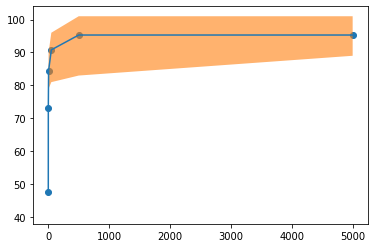

In [95]:
plt.scatter(alphas, ress)
plt.plot(alphas, ress)
plt.fill_between(alphas, mins, maxs, alpha=0.6)   
plt.show()